In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from skimage import color
from skimage import io
from scipy.ndimage import convolve, generate_binary_structure
import numba
from numba import jit
import time

The heat equation $$\alpha \nabla^2 u = \frac{\partial u}{ \partial t}$$

* $u$ is temperature
* $\alpha$ is the thermal diffusivity
* $t$ is time

in two dimensions and in discrete form, can be written as

$$\alpha \left( \frac{u_{i+1,j}^{(m)} -2u_{i,j}^{(m)} + u_{i-1,j}^{(m)}}{\Delta x^2} + \frac{u_{i,j+1}^{(m)} -2u_{i,j}^{(m)} + u_{i,j-1}^{(m)}}{\Delta y^2}\right) = \frac{u_j^{(m+1)} - u_j^{(m)}}{\Delta t} $$ 

Can rearrange to solve for $m+1$ 

$$ u_j^{(m+1)} = u_j^{(m)} + \alpha \frac{\Delta t}{\Delta x^2} \left( u_{i+1,j}^{(m)} + u_{i-1,j}^{(m)} +  u_{i,j+1}^{(m)} + u_{i,j-1}^{(m)}  -4u_{i,j}^{(m)} \right) $$

In [2]:
edge = np.linspace(0, 1, 100)
xv, yv = np.meshgrid(edge, edge)

Load image. Find locations of the turkey pixels in boolean 2d array

In [4]:
img = color.rgb2gray(io.imread('../../output/turkey.png'))
img = np.flip(img, axis=0)
is_turkey = img<0.9

<ipython-input-4-04ae653af5fc>:1: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img = color.rgb2gray(io.imread('../../output/turkey.png'))


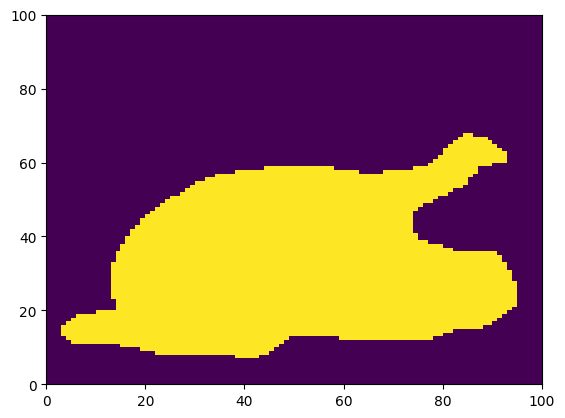

In [5]:
plt.pcolormesh(is_turkey)
plt.show()

Thermal diffusivity of the turkey:

In [6]:
a_turk = 1.32e-7

Oven and initial turkey temperature

In [7]:
rawturk_temp = 273.15 + 25
oven_temp = 273.15 + 165

Set the turkey to the initial turkey temperature and the oven to the preheated oven temperature

In [8]:
T0 = np.ones([100,100]) * oven_temp
T0[is_turkey] = rawturk_temp

Set the dimensions of the problem

In [9]:
x = 0.5
dx = 0.5/100
dt = 1

Compute $s = \alpha \Delta t / \Delta x^2$. $s$ needs to be much less than 1/4 for this to work.

In [10]:
s = a_turk * dt / dx**2
s

0.005279999999999999

In [11]:
kern = generate_binary_structure(2,1).astype(float)
kern[1,1] = -4
kern

array([[ 0.,  1.,  0.],
       [ 1., -4.,  1.],
       [ 0.,  1.,  0.]])

In [37]:
def solve_heat_pythonic(T0, is_turkey, N_times):
    T_curr = T0.copy()
    for t in range(1, N_times):
        T_curr = T_curr + s * convolve(T_curr, kern)
        T_curr[~is_turkey] = oven_temp
    return T_curr

In [38]:
t1 = time.perf_counter()
T111 = solve_heat_pythonic(T0, is_turkey, 1000)
t2 = time.perf_counter()
print(t2-t1)

0.12048260000000255


In [39]:
@numba.jit("f8[:,:](f8[:,:], b1[:,:], i8)", nopython=True, nogil=True)
def solve_heat_numba(T0, is_turkey, N_times):
    x_length, y_length = T0.shape
    T_curr = T0.copy()
    for t in range(1,N_times):
        for i in range(1, x_length-1):
            for j in range(1, y_length-1):
                if is_turkey[j][i]:
                    T_curr[j][i] = T_curr[j][i] + s * (T_curr[j+1][i] + T_curr[j-1][i] +\
                                                    T_curr[j][i+1] + T_curr[j][i-1] -\
                                                    4*T_curr[j][i])          
    return T_curr

In [46]:
t1 = time.perf_counter()
T222 = solve_heat_numba(T0, is_turkey, 1000)
t2 = time.perf_counter()
print(t2-t1)

0.03812899999996944


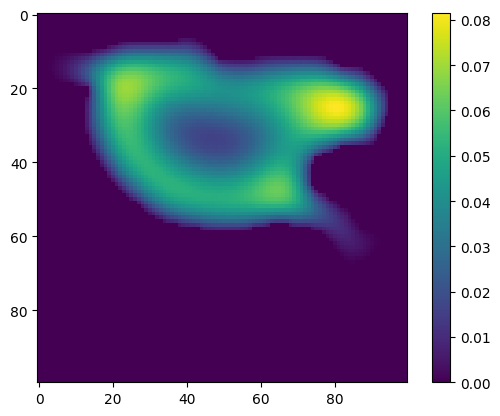

In [47]:
plt.imshow(T222-T111)
plt.colorbar()
plt.show()

Plot

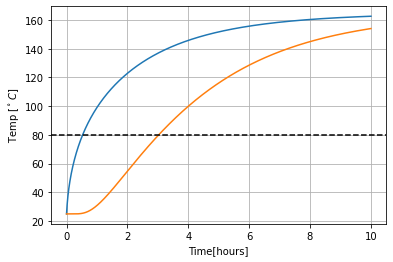

In [79]:
plt.plot(t, avg_temp, label='average')
plt.plot(t, min_temp, label='average')
plt.axhline(80, color='k', ls='--')
plt.xlabel('Time[hours]')
plt.ylabel('Temp [$^\circ C$]')
plt.grid()